# Модель Nelson–Siegel

$$
y(t)=\beta_{0}+\beta_{1}\,\frac{1-e^{-t/\tau}}{t/\tau}+\beta_{2}\left(\frac{1-e^{-t/\tau}}{t/\tau}-e^{-t/\tau}\right)
$$

**Метод обучения:** `scipy.optimize.least_squares` с методом `'trf'`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import seaborn as sns
import json

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'dejavusans'

In [2]:
df = pd.read_csv('../data/data.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.set_index('date', inplace=True)

In [3]:
class NelsonSiegelModel:
    def __init__(self):
        self.params = None
        self.fitted = False
        self.optimization_result = None
        self.optimization_history = []

    def yield_curve(self, t, beta0, beta1, beta2, tau):
        t = np.array(t, dtype=float)
        t = np.where(t < 1e-10, 1e-10, t)
        ratio = t / tau
        term1 = (1 - np.exp(-ratio)) / ratio
        term2 = term1 - np.exp(-ratio)
        return beta0 + beta1 * term1 + beta2 * term2

    def residuals_function(self, params, t, observed_yields):
        beta0, beta1, beta2, tau = params
        predicted_yields = self.yield_curve(t, beta0, beta1, beta2, tau)
        return observed_yields - predicted_yields

    def fit(self, t, yields, initial_params=None, method='trf', track_history=False):
        if initial_params is None:
            beta0 = np.mean(yields[-3:])
            beta1 = yields[0] - beta0
            beta2 = 0.0
            tau = 1.0
            initial_params = [beta0, beta1, beta2, tau]

        bounds = ([-np.inf, -np.inf, -np.inf, 0.05], [np.inf, np.inf, np.inf, 30.0])
        
        self.optimization_history = []
        
        def callback(params):
            if track_history:
                residuals = self.residuals_function(params, t, yields)
                cost = np.sum(residuals**2)
                self.optimization_history.append({
                    'iteration': len(self.optimization_history),
                    'cost': float(cost),
                    'params': params.tolist()
                })

        result = least_squares(
            self.residuals_function,
            initial_params,
            args=(t, yields),
            method=method,
            bounds=bounds,
            ftol=1e-9,
            max_nfev=10000,
            x_scale='jac',
            callback=callback
        )

        self.params = result.x
        self.fitted = True
        self.optimization_result = result
        return self

    def predict(self, t):
        if not self.fitted:
            raise ValueError("Модель не обучена")
        beta0, beta1, beta2, tau = self.params
        return self.yield_curve(t, beta0, beta1, beta2, tau)

    def get_params_dict(self):
        if not self.fitted:
            return None
        return {
            'β₀': self.params[0],
            'β₁': self.params[1],
            'β₂': self.params[2],
            'τ': self.params[3]
        }

    def score(self, t, yields):
        if not self.fitted:
            raise ValueError("Модель не обучена")
        predicted = self.predict(t)
        ss_res = np.sum((yields - predicted) ** 2)
        ss_tot = np.sum((yields - np.mean(yields)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        rmse = np.sqrt(np.mean((yields - predicted) ** 2))
        mae = np.mean(np.abs(yields - predicted))
        return {'R²': r2, 'RMSE': rmse, 'MAE': mae}

In [4]:
sample_date = df.index[0]
maturities = df.columns.astype(float).values
yields_sample = df.iloc[0].values

model = NelsonSiegelModel()
model.fit(maturities, yields_sample, method='trf', track_history=True)

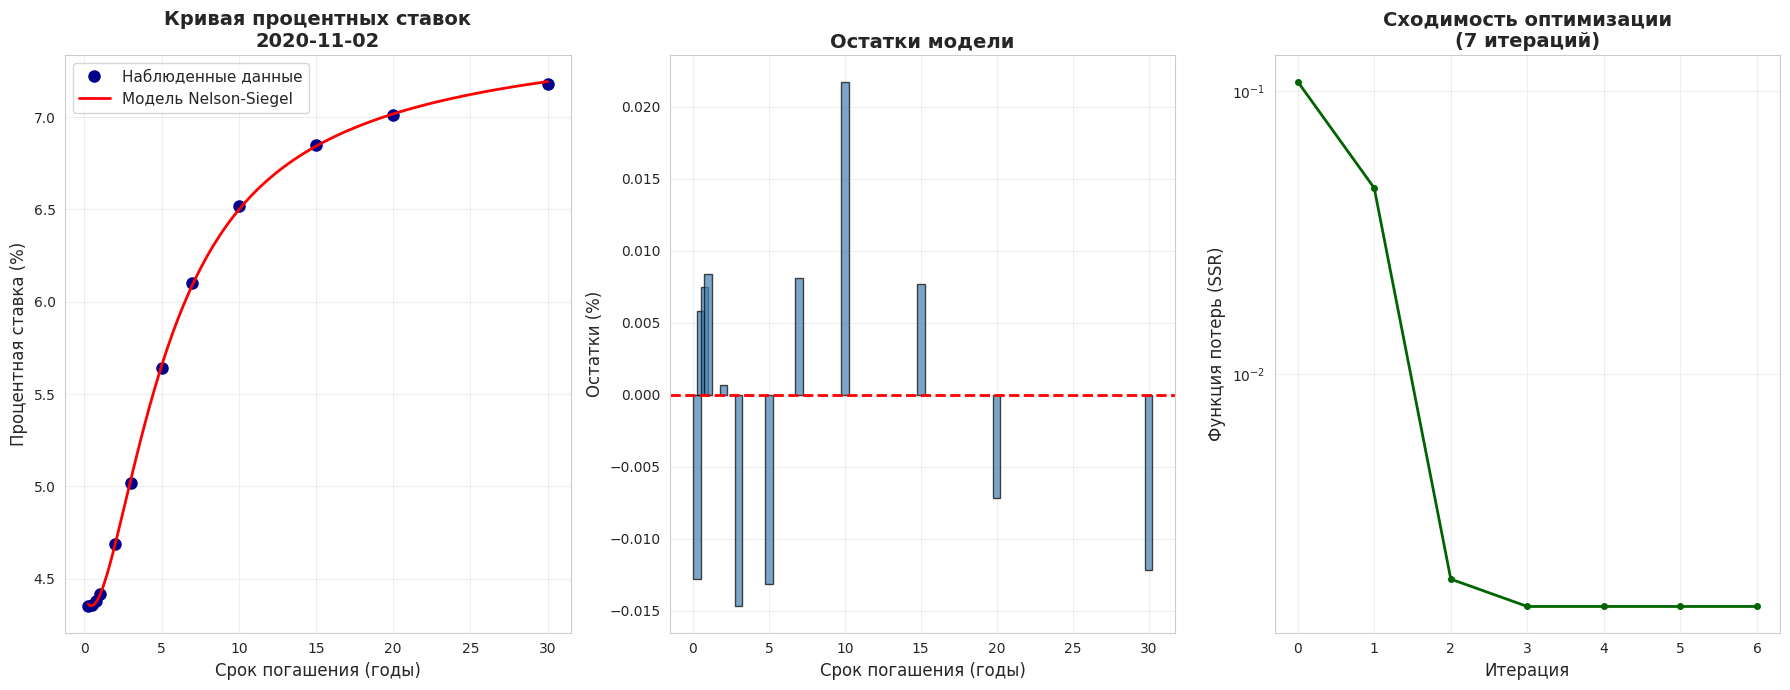

In [5]:
tau_fine = np.linspace(maturities.min(), maturities.max(), 300)
predicted_fine = model.predict(tau_fine)
predicted_original = model.predict(maturities)

fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(maturities, yields_sample, 'o', markersize=8, label='Наблюденные данные', color='darkblue')
ax1.plot(tau_fine, predicted_fine, '-', linewidth=2, label='Модель Nelson-Siegel', color='red')
ax1.set_xlabel('Срок погашения (годы)', fontsize=12)
ax1.set_ylabel('Процентная ставка (%)', fontsize=12)
ax1.set_title(f'Кривая процентных ставок\n{sample_date.date()}', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

residuals = yields_sample - predicted_original
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(maturities, residuals, width=0.5, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Срок погашения (годы)', fontsize=12)
ax2.set_ylabel('Остатки (%)', fontsize=12)
ax2.set_title('Остатки модели', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
if len(model.optimization_history) > 0:
    costs = [h['cost'] for h in model.optimization_history]
    ax3.plot(range(len(costs)), costs, '-o', linewidth=2, markersize=4, color='darkgreen')
    ax3.set_xlabel('Итерация', fontsize=12)
    ax3.set_ylabel('Функция потерь (SSR)', fontsize=12)
    ax3.set_title(f'Сходимость оптимизации\n({len(costs)} итераций)', fontsize=14, fontweight='bold')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'История не записана', ha='center', va='center', fontsize=12)
    ax3.set_title('Сходимость оптимизации', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Обучение на всех датах

In [6]:
from tqdm.auto import tqdm

results = {
    'date': [],
    'beta0': [],
    'beta1': [],
    'beta2': [],
    'tau': [],
    'rmse': [],
    'r2': [],
    'mae': [],
    'convergence': []
}

optimization_history = {}

for date_idx in tqdm(range(len(df)), desc="Обучение Nelson–Siegel"):
    date = df.index[date_idx]
    yields = df.iloc[date_idx].values
    
    model_temp = NelsonSiegelModel()
    model_temp.fit(maturities, yields, method='trf', track_history=True)
    
    results['date'].append(date)
    results['beta0'].append(model_temp.params[0])
    results['beta1'].append(model_temp.params[1])
    results['beta2'].append(model_temp.params[2])
    results['tau'].append(model_temp.params[3])
    
    metrics = model_temp.score(maturities, yields)
    results['rmse'].append(metrics['RMSE'])
    results['r2'].append(metrics['R²'])
    results['mae'].append(metrics['MAE'])
    results['convergence'].append(model_temp.optimization_result.success)
    
    optimization_history[str(date)] = model_temp.optimization_history

results_df = pd.DataFrame(results)
results_df.set_index('date', inplace=True)

iterations_count = [len(optimization_history[str(date)]) for date in results_df.index]
results_df['iterations'] = iterations_count

Обучение Nelson–Siegel:   0%|          | 0/1256 [00:00<?, ?it/s]

In [7]:
## Анализ сходимости оптимизации

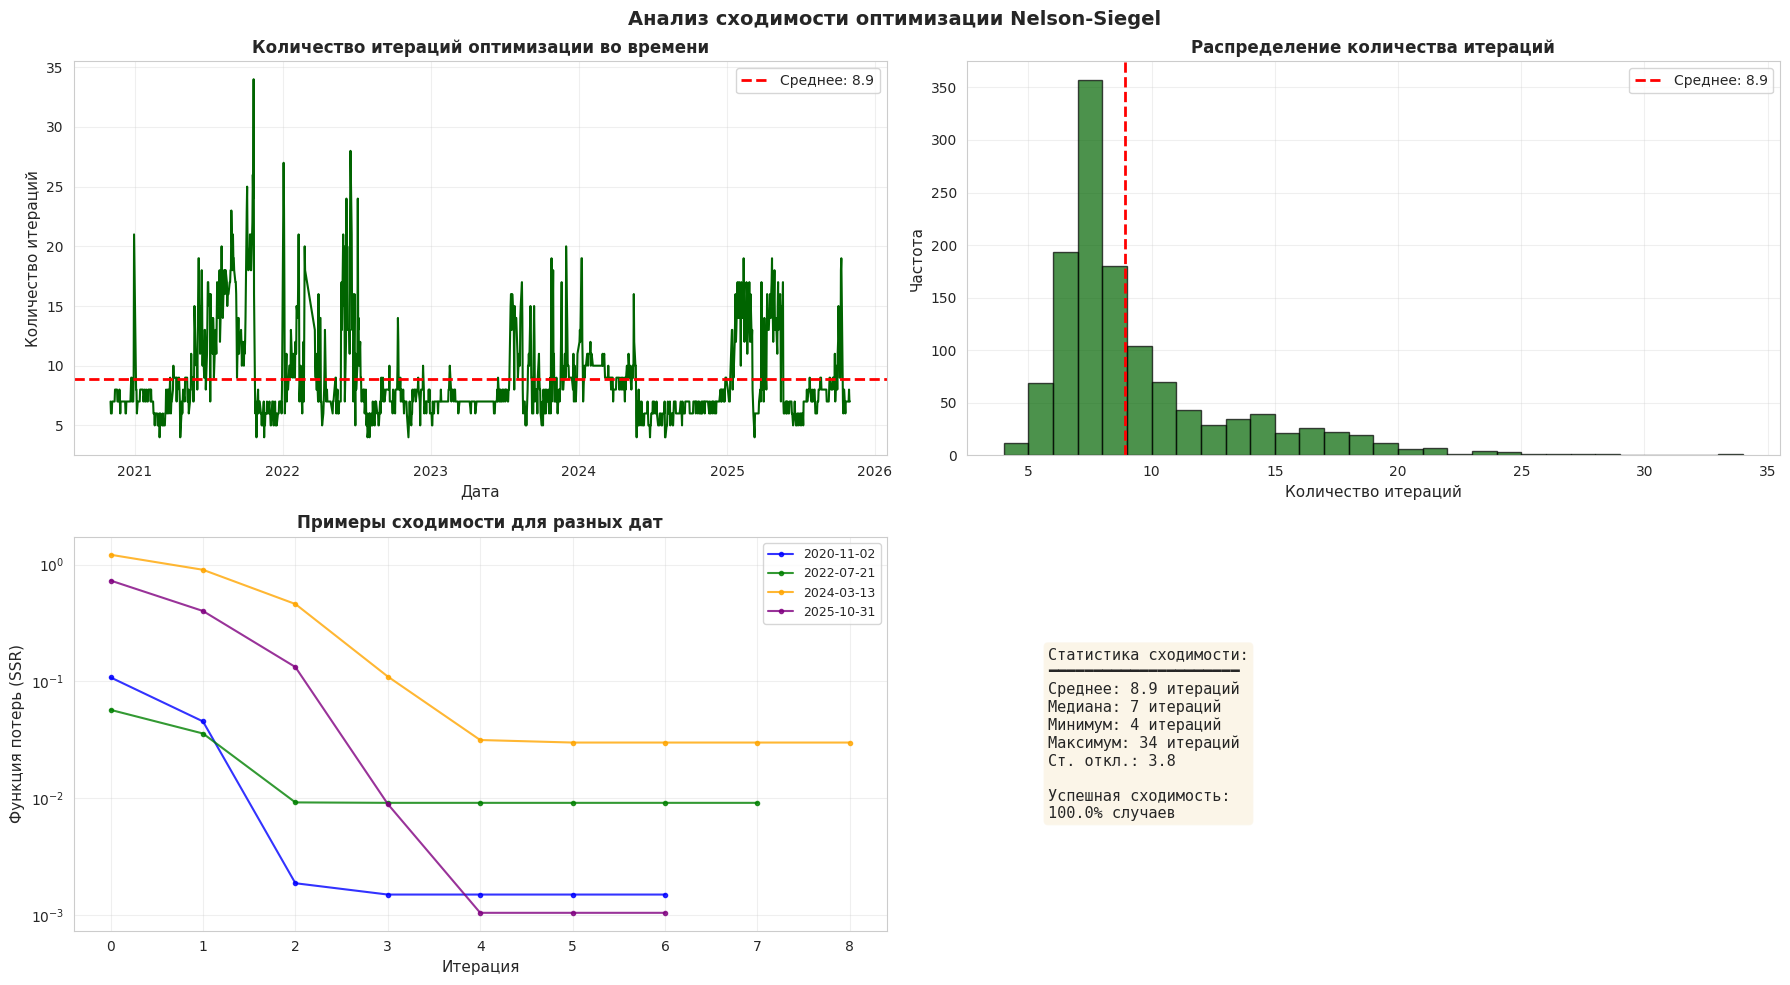

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0, 0].plot(results_df.index, results_df['iterations'], linewidth=1.5, color='darkgreen')
axes[0, 0].axhline(y=results_df['iterations'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Среднее: {results_df["iterations"].mean():.1f}')
axes[0, 0].set_ylabel('Количество итераций', fontsize=11)
axes[0, 0].set_xlabel('Дата', fontsize=11)
axes[0, 0].set_title('Количество итераций оптимизации во времени', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(results_df['iterations'], bins=30, alpha=0.7, color='darkgreen', edgecolor='black')
axes[0, 1].axvline(results_df['iterations'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Среднее: {results_df["iterations"].mean():.1f}')
axes[0, 1].set_xlabel('Количество итераций', fontsize=11)
axes[0, 1].set_ylabel('Частота', fontsize=11)
axes[0, 1].set_title('Распределение количества итераций', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

sample_indices = np.linspace(0, len(results_df)-1, 4, dtype=int)
colors_samples = ['blue', 'green', 'orange', 'purple']
for idx, color in zip(sample_indices, colors_samples):
    date = results_df.index[idx]
    hist = optimization_history[str(date)]
    if len(hist) > 0:
        costs = [h['cost'] for h in hist]
        axes[1, 0].plot(range(len(costs)), costs, '-o', linewidth=1.5, markersize=3, 
                       label=f'{date.date()}', color=color, alpha=0.8)
axes[1, 0].set_xlabel('Итерация', fontsize=11)
axes[1, 0].set_ylabel('Функция потерь (SSR)', fontsize=11)
axes[1, 0].set_title('Примеры сходимости для разных дат', fontsize=12, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

stats_text = f"""Статистика сходимости:
━━━━━━━━━━━━━━━━━━━━━
Среднее: {results_df['iterations'].mean():.1f} итераций
Медиана: {results_df['iterations'].median():.0f} итераций
Минимум: {results_df['iterations'].min():.0f} итераций
Максимум: {results_df['iterations'].max():.0f} итераций
Ст. откл.: {results_df['iterations'].std():.1f}

Успешная сходимость:
{100 * results_df['convergence'].mean():.1f}% случаев"""

axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
               family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
axes[1, 1].axis('off')

plt.suptitle('Анализ сходимости оптимизации Nelson-Siegel', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [9]:
results_df[['beta0', 'beta1', 'beta2', 'tau']].describe()


,beta0,beta1,beta2,tau
count,1256.000000,1256.000000,1256.000000,1256.000000
mean,11.637569,0.074409,-1.303722,1.955108
std,2.811608,3.918157,4.735401,2.303446
min,7.163259,-5.595713,-14.784811,0.149762
25%,8.907176,-3.038391,-4.141233,0.803338
50%,11.937956,-0.765390,-2.283203,1.329405
75%,14.130864,2.314774,0.560427,1.896617
max,18.424717,10.798748,12.255980,25.509056


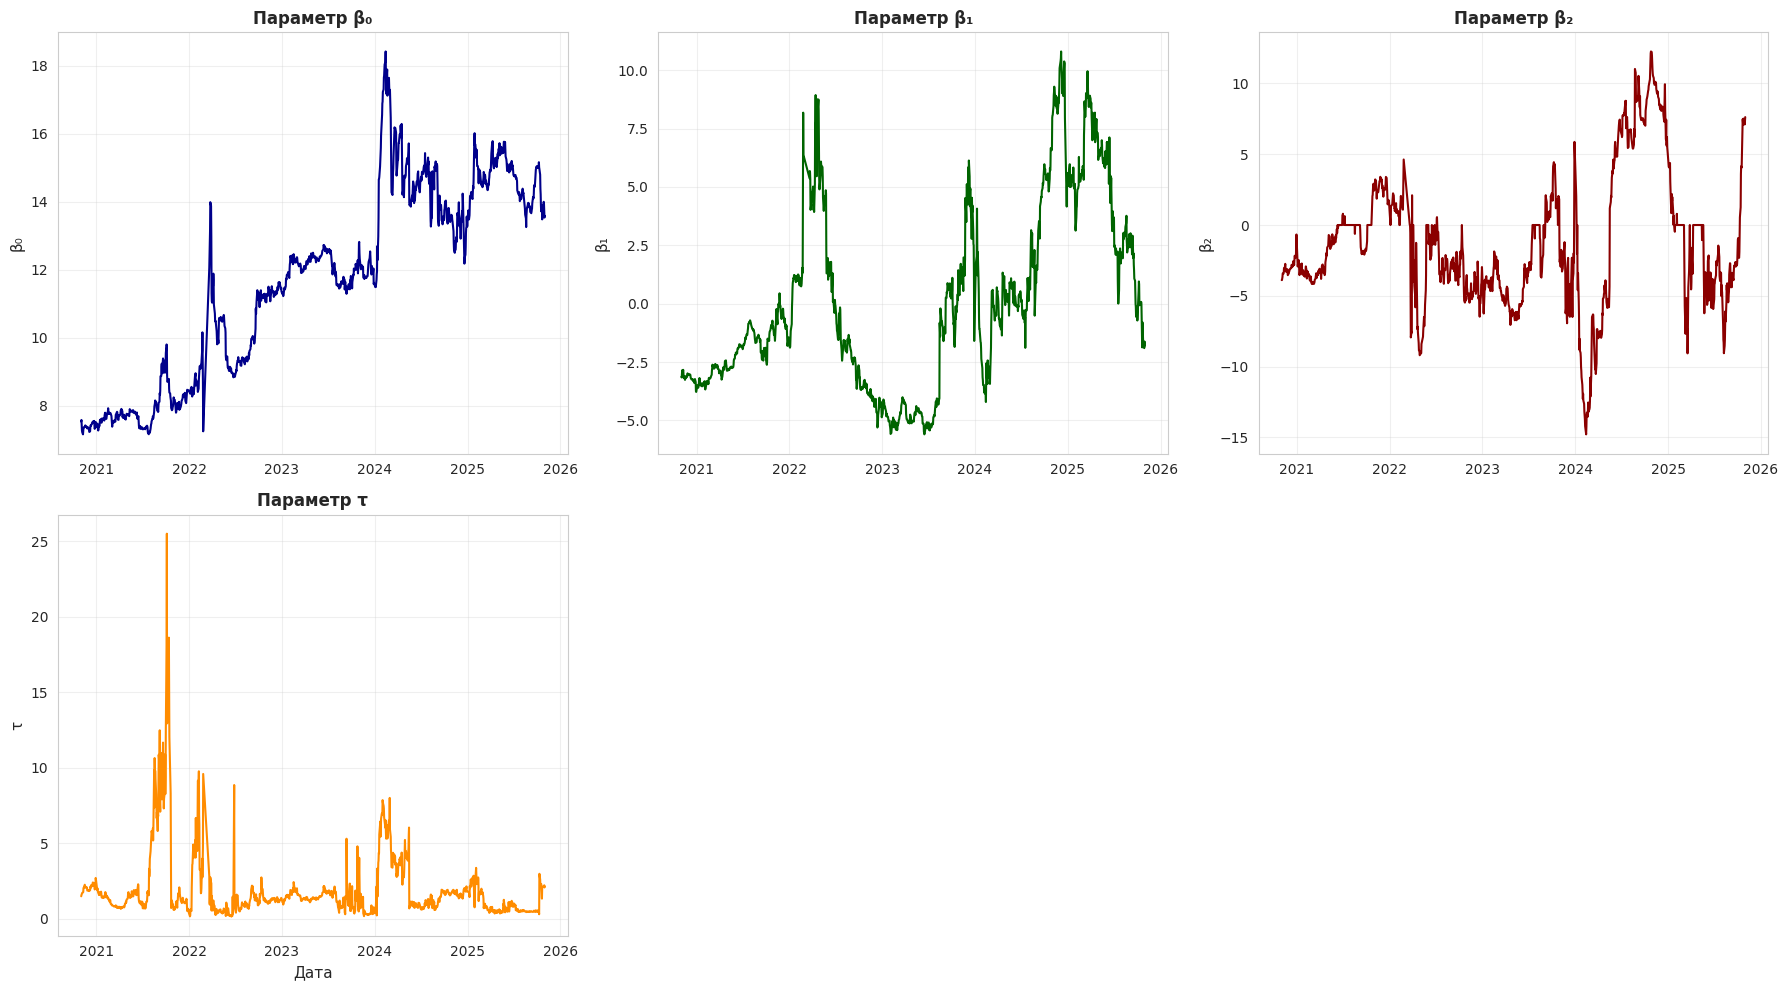

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].plot(results_df.index, results_df['beta0'], linewidth=1.5, color='darkblue')
axes[0, 0].set_title('Параметр β₀', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('β₀', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(results_df.index, results_df['beta1'], linewidth=1.5, color='darkgreen')
axes[0, 1].set_title('Параметр β₁', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('β₁', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(results_df.index, results_df['beta2'], linewidth=1.5, color='darkred')
axes[0, 2].set_title('Параметр β₂', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('β₂', fontsize=11)
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].plot(results_df.index, results_df['tau'], linewidth=1.5, color='darkorange')
axes[1, 0].set_title('Параметр τ', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('τ', fontsize=11)
axes[1, 0].set_xlabel('Дата', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].axis('off')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

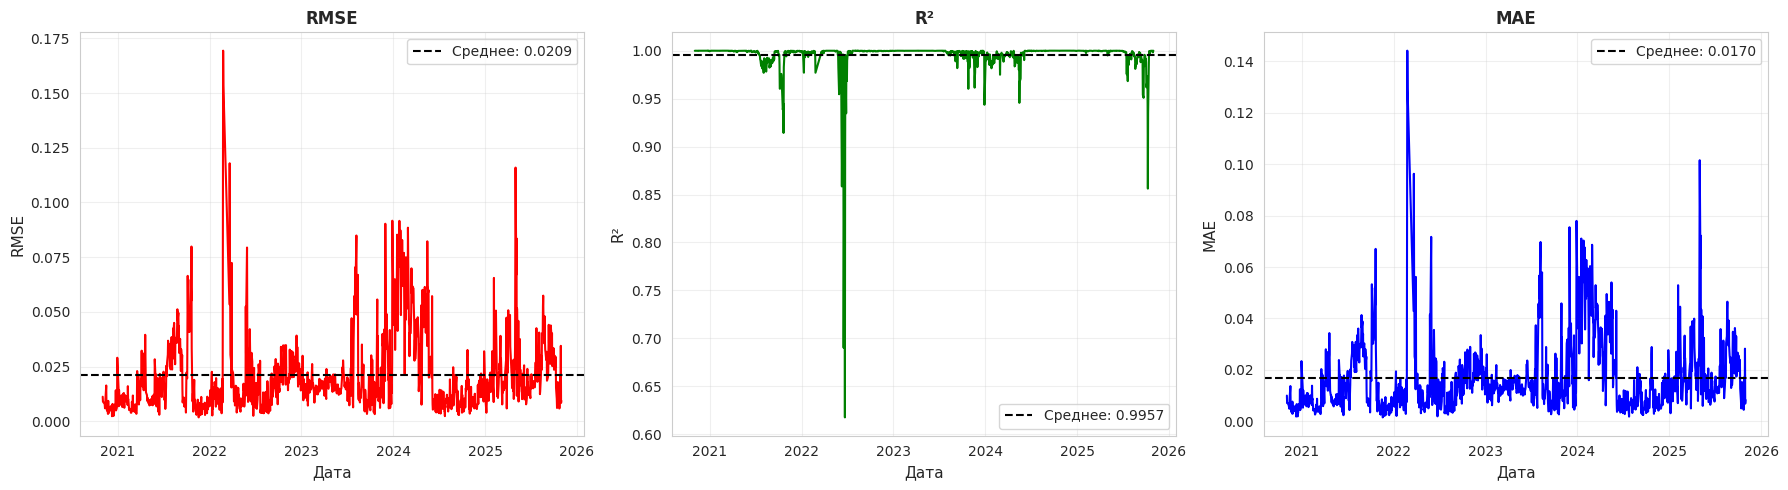

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(results_df.index, results_df['rmse'], linewidth=1.5, color='red')
axes[0].set_title('RMSE', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=11)
axes[0].set_xlabel('Дата', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=results_df['rmse'].mean(), color='black', linestyle='--',
                label=f'Среднее: {results_df["rmse"].mean():.4f}')
axes[0].legend()

axes[1].plot(results_df.index, results_df['r2'], linewidth=1.5, color='green')
axes[1].set_title('R²', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R²', fontsize=11)
axes[1].set_xlabel('Дата', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=results_df['r2'].mean(), color='black', linestyle='--',
                label=f'Среднее: {results_df["r2"].mean():.4f}')
axes[1].legend()

axes[2].plot(results_df.index, results_df['mae'], linewidth=1.5, color='blue')
axes[2].set_title('MAE', fontsize=12, fontweight='bold')
axes[2].set_ylabel('MAE', fontsize=11)
axes[2].set_xlabel('Дата', fontsize=11)
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=results_df['mae'].mean(), color='black', linestyle='--',
                label=f'Среднее: {results_df["mae"].mean():.4f}')
axes[2].legend()

plt.tight_layout()
plt.show()

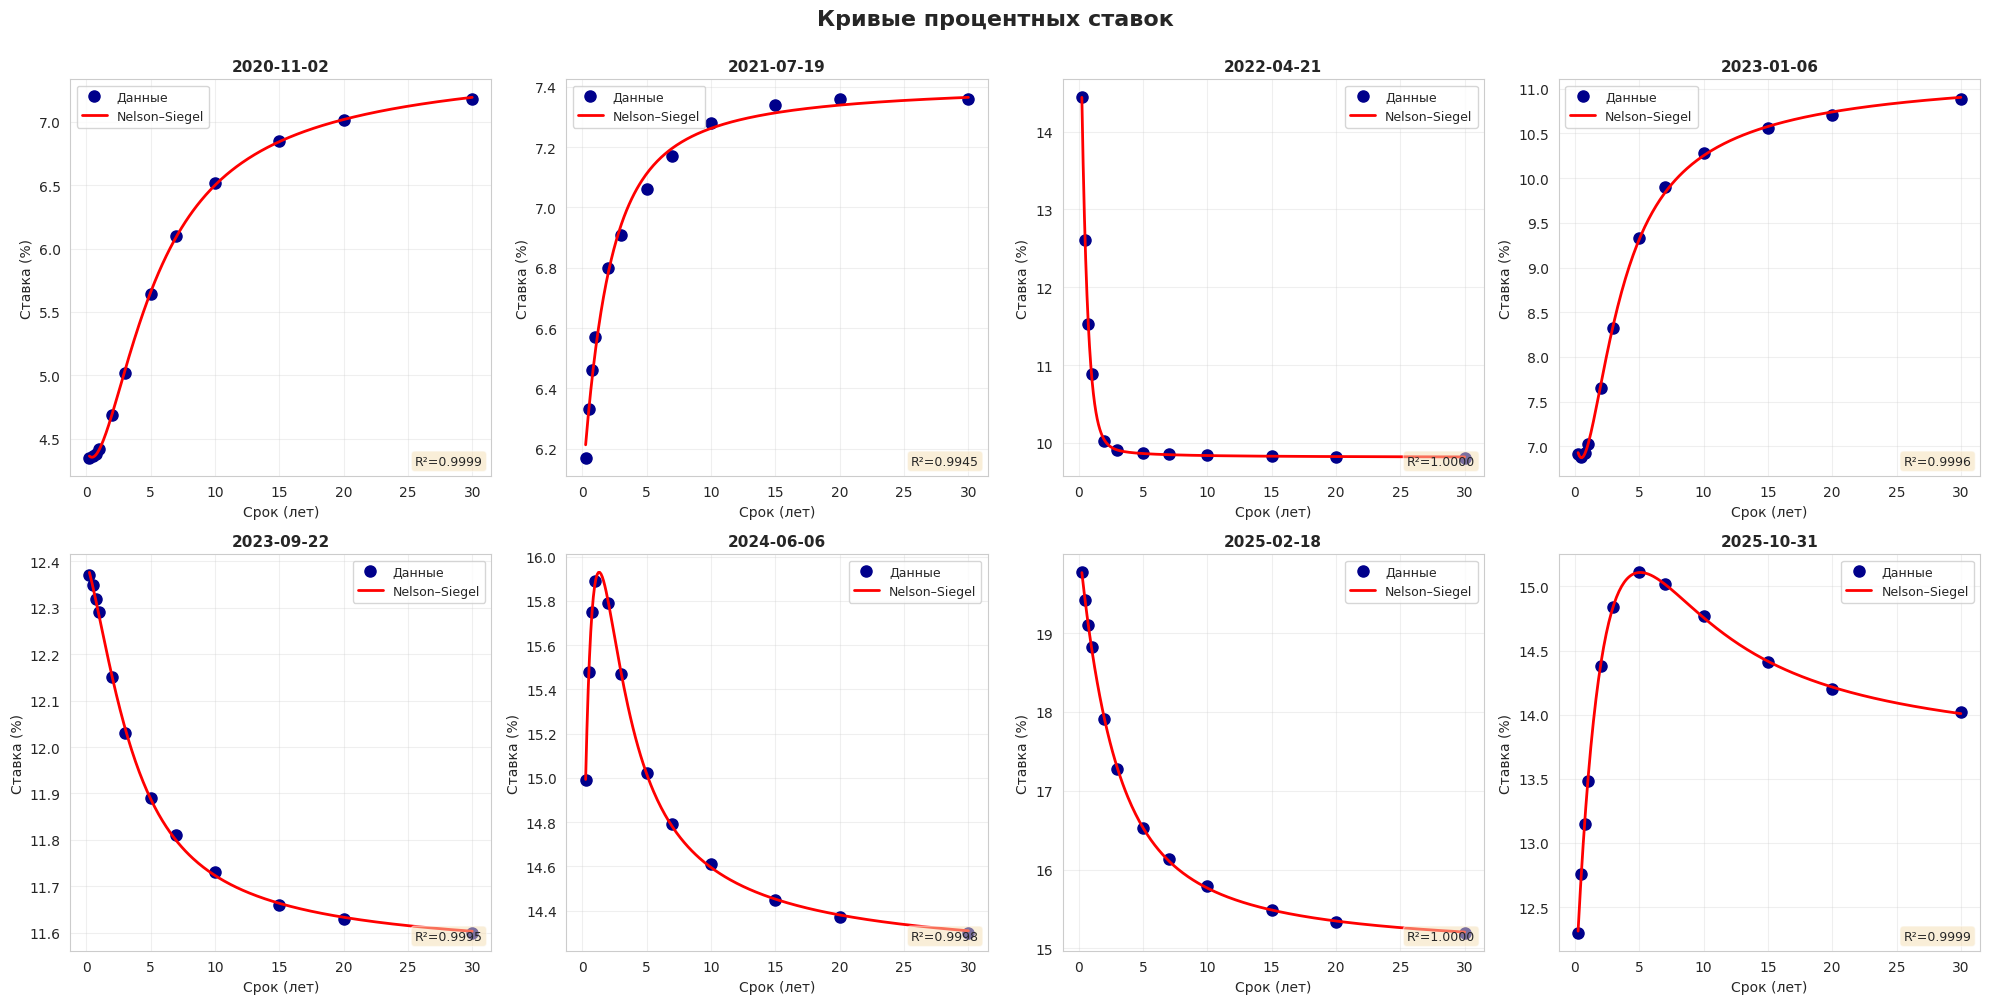

In [12]:
n_samples = 8
indices = np.linspace(0, len(df)-1, n_samples, dtype=int)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

tau_fine = np.linspace(maturities.min(), maturities.max(), 300)

for i, idx in enumerate(indices):
    date = df.index[idx]
    yields = df.iloc[idx].values
    
    model_viz = NelsonSiegelModel()
    model_viz.fit(maturities, yields, method='trf')
    predicted_fine = model_viz.predict(tau_fine)
    
    axes[i].plot(maturities, yields, 'o', markersize=8, label='Данные', color='darkblue')
    axes[i].plot(tau_fine, predicted_fine, '-', linewidth=2, label='Nelson–Siegel', color='red')
    axes[i].set_title(f'{date.date()}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Срок (лет)', fontsize=10)
    axes[i].set_ylabel('Ставка (%)', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)
    
    metrics = model_viz.score(maturities, yields)
    axes[i].text(0.98, 0.02, f'R²={metrics["R²"]:.4f}',
                 transform=axes[i].transAxes, fontsize=9,
                 verticalalignment='bottom', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Кривые процентных ставок', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [13]:
results_df.to_csv('../results/nelson_siegel_results.csv')

with open('../results/nelson_siegel_optimization_history.json', 'w') as f:
    json.dump(optimization_history, f)

summary = {
    'Метрика': ['RMSE (среднее)', 'RMSE (мин)', 'RMSE (макс)',
                'R² (среднее)', 'R² (мин)', 'R² (макс)',
                'MAE (среднее)', 'MAE (мин)', 'MAE (макс)',
                'Успешная сходимость (%)'],
    'Значение': [
        results_df['rmse'].mean(),
        results_df['rmse'].min(),
        results_df['rmse'].max(),
        results_df['r2'].mean(),
        results_df['r2'].min(),
        results_df['r2'].max(),
        results_df['mae'].mean(),
        results_df['mae'].min(),
        results_df['mae'].max(),
        100 * results_df['convergence'].mean()
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv('../results/nelson_siegel_summary.csv', index=False)
